# 🍄 Mushroom data





---

#### Name: 吳原博
#### Student ID: 0816004

---

## 助教好 😀
> 程式碼的解釋會放在每個程式碼區塊上方的 markdown 裡，謝謝!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib3
from tabulate import tabulate
import math
from sklearn.naive_bayes import *
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.metrics import *
from IPython.display import display

%matplotlib inline

# Variables

In [2]:
mushroom = ['cap-shape','cap-surface','cap-color','bruises?','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat']
mush_atr = [['b','c','x','f','k','s'],['f','g','y','s'],['n','b','c','g','r','p','u','e','w','y'],['t','f'],['a','l','c','y','f','m','n','p','s'],['a','d','f','n'],['c','w','d'],['b','n'],['k','n','b','h','g','r','o','p','u','e','w','y'],['e','t'],['b','c','u','e','z','r','?'],['f','y','k','s'],['f','y','k','s'],['n','b','c','g','o','p','e','w','y'],['n','b','c','g','o','p','e','w','y'],['p','u'],['n','o','w','y'],['n','o','t'],['c','e','f','l','n','p','s','z'],['k','n','b','h','r','o','u','w','y'],['a','c','n','s','v','y'],['g','l','m','p','u','w','d']]
iris = ['sepal_length','sepal_width','petal_length','petal_width','class']

# Data Input and Visualization

- 這次作業我使用 pandas 讀取資料，並且透過 matplotlib 來視覺化呈現資料<br>
<br>
- 程式碼的前兩段是將資料轉換成長條圖的前處理，我把資料的每個 feature 和數量儲存成對應的 dictionary，存放到 list 中方便後面以迴圈畫圖<br>
後面兩段大多是為了美化長條圖的程式碼

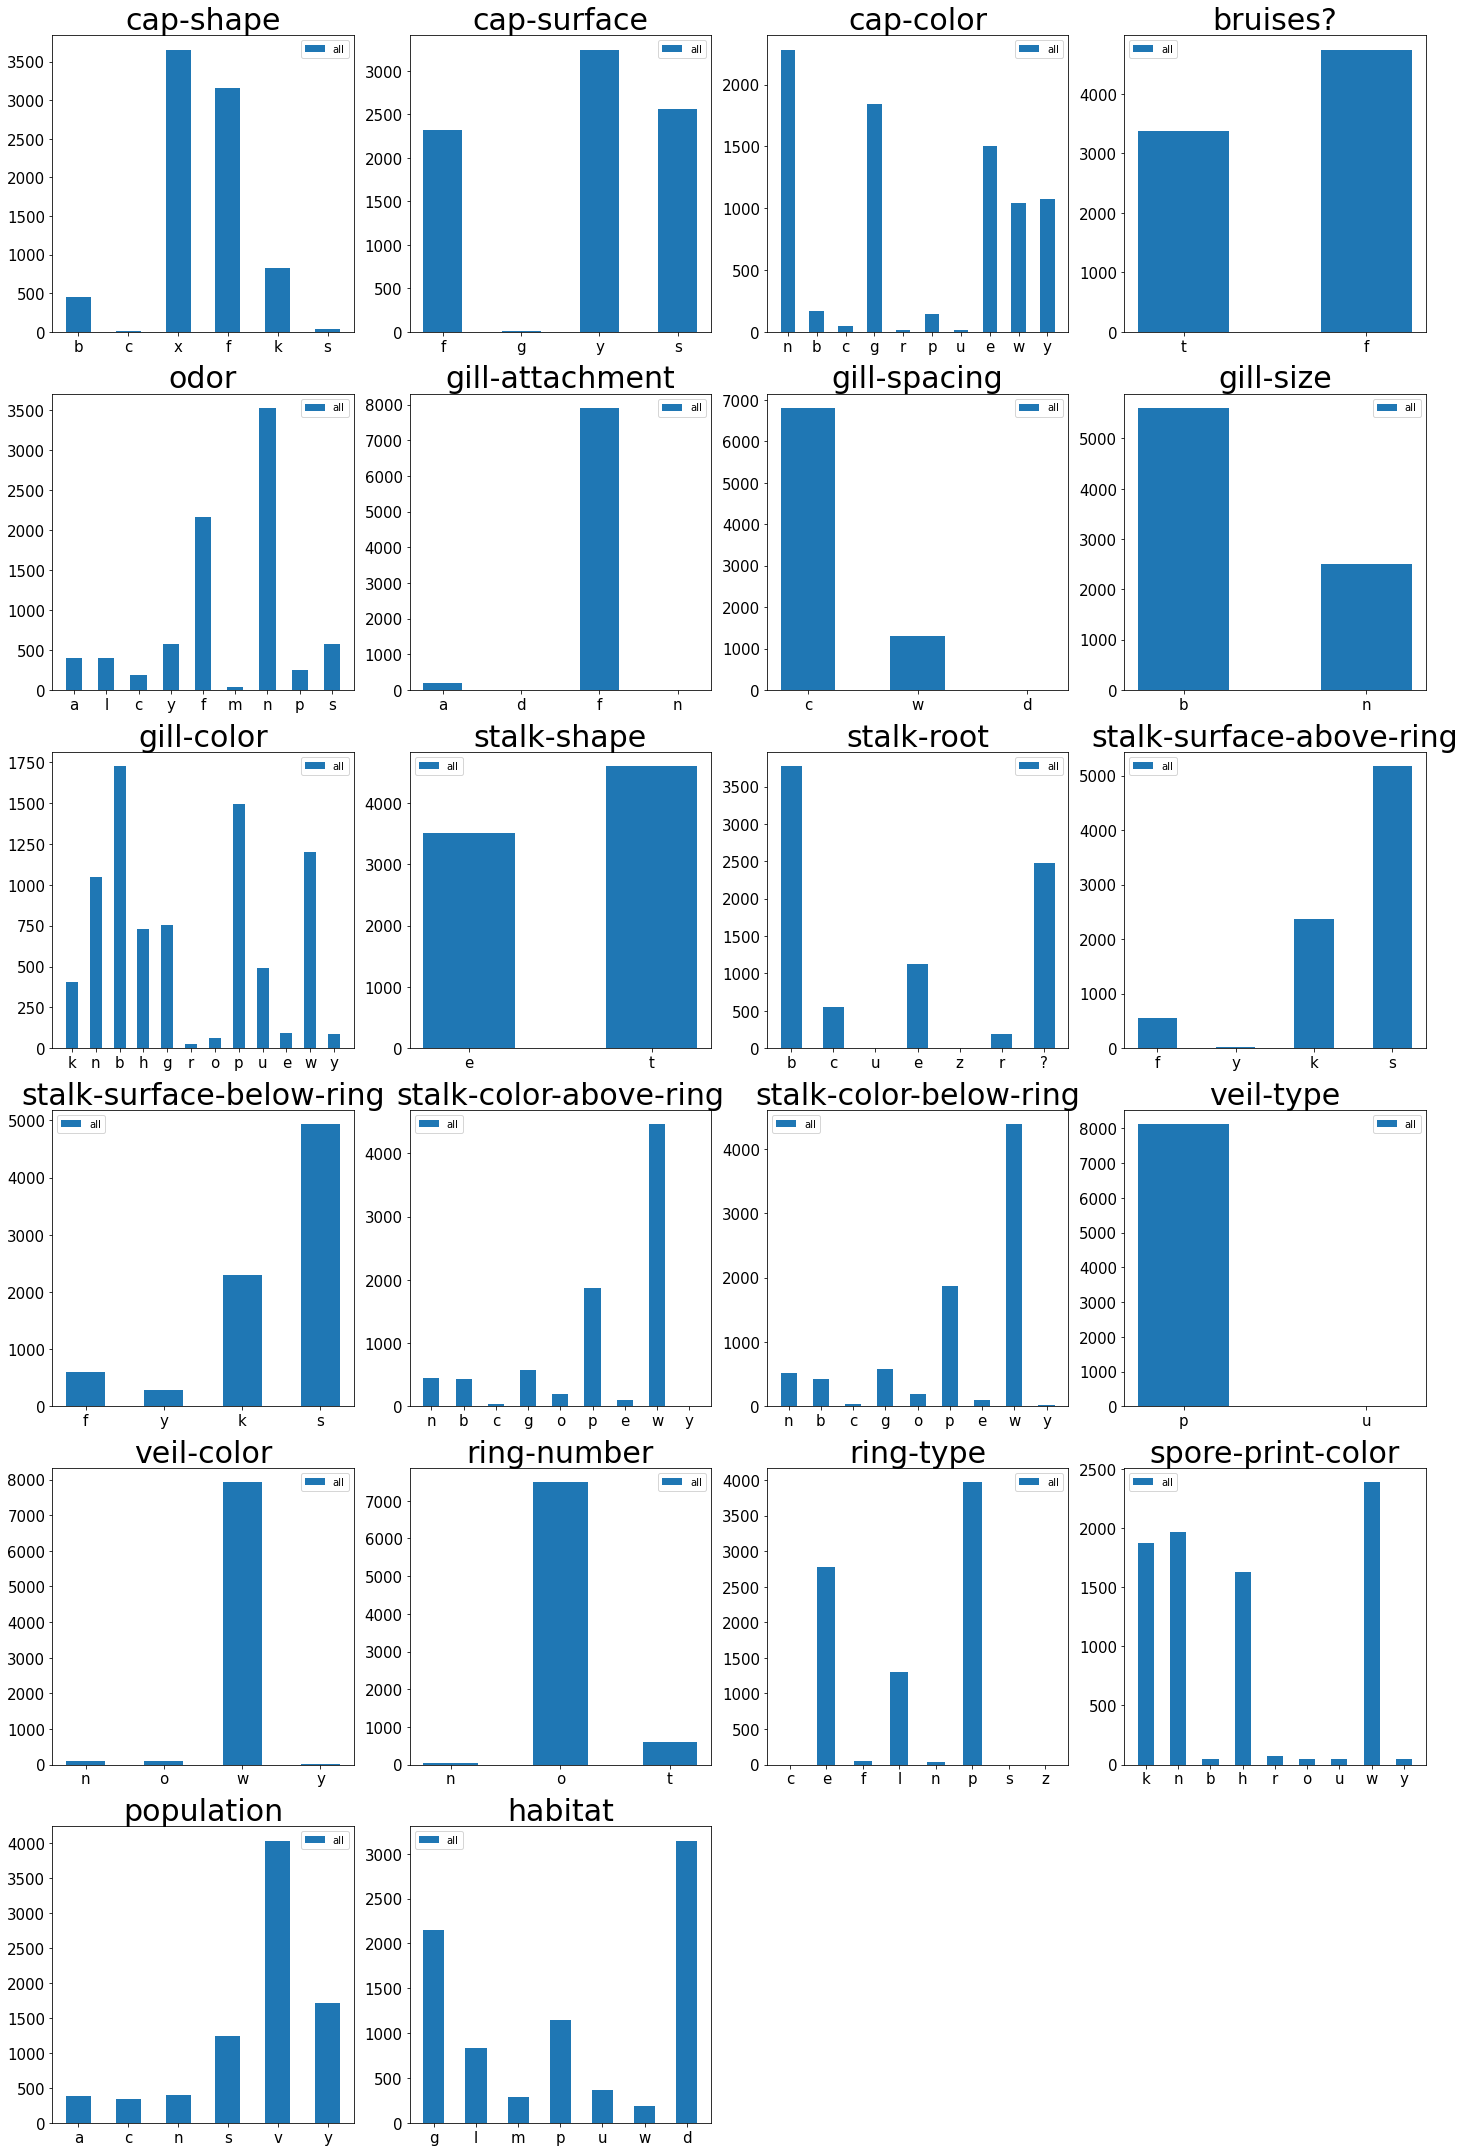

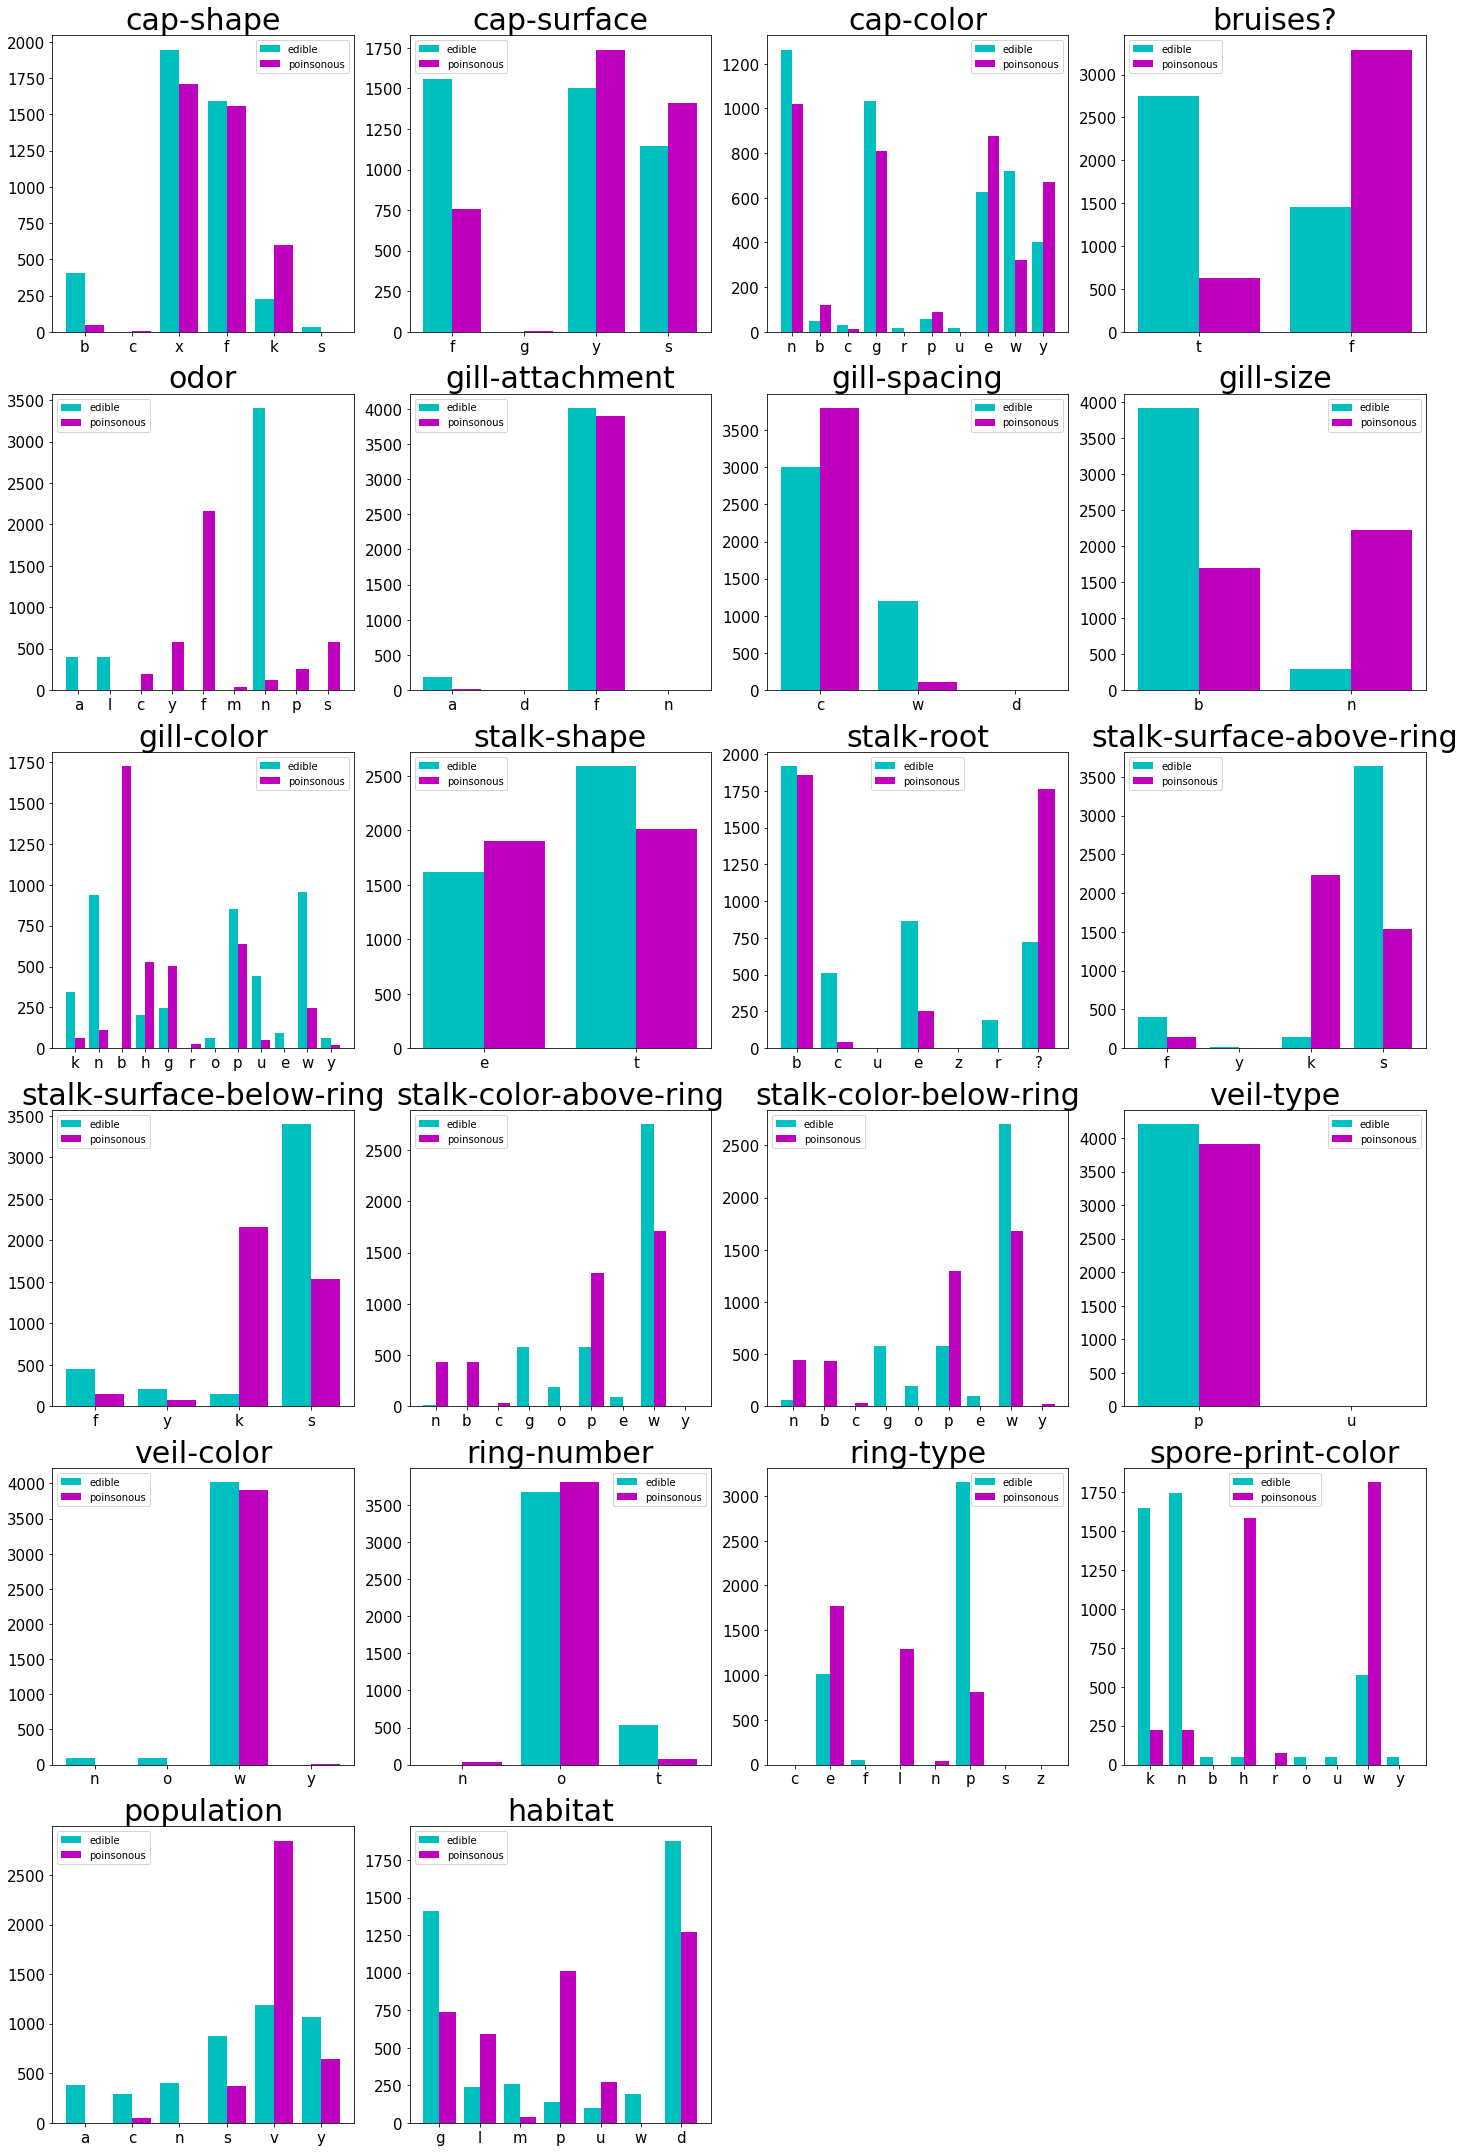

In [3]:
# mushroom data
df_mush = pd.read_csv('agaricus-lepiota.data',header = None)
# data management
data = []
for i in range(df_mush.shape[1]-1):
    static = {}
    for j in range(len(mush_atr[i])):
        static[mush_atr[i][j]] = 0
    group = df_mush.groupby(i+1)
    for g in group:
        static[g[0]] = g[1].count()[0]
    data.append(static)
# split data into edible and poisonous
data_e = []
data_p = []
group = df_mush.groupby(0)
for i in range(df_mush.shape[1]-1):
    static_e = {}
    static_p = {}
    for j in range(len(mush_atr[i])):
        static_e[mush_atr[i][j]] = 0
        static_p[mush_atr[i][j]] = 0
    for g in group:
        group2 = g[1].groupby(i+1)
        for g2 in group2:
            if(g[0] == 'e'):
                static_e[g2[0]] = g2[1].count()[0]
            elif(g[0] == 'p'):
                static_p[g2[0]] = g2[1].count()[0]
    data_e.append(static_e)
    data_p.append(static_p)

parameters = {'xtick.labelsize': 15,'ytick.labelsize': 15}
plt.rcParams.update(parameters)
# draw the plot of label 'all'
fig = plt.figure(figsize=(20,30))
for i in range(len(data)):
    ax = fig.add_subplot(6,4,i+1)
    ax.set_title(mushroom[i],fontsize=30)
    ax.bar(data[i].keys(),data[i].values(),width=0.5,label='all')
    plt.legend()
plt.tight_layout()
plt.show()
# draw the plot of label 'edible' and 'poisonous'
fig = plt.figure(figsize=(20,30))
for i in range(len(data)):
    ax = fig.add_subplot(6,4,i+1)
    ax.set_title(mushroom[i],fontsize=30)
    ax.bar(data_e[i].keys(),data_e[i].values(),width=-0.4,color='c',label='edible',align='edge')
    ax.bar(data_p[i].keys(),data_p[i].values(),width=0.4,color='m',label='poinsonous',align='edge')
    plt.legend()
plt.tight_layout()
plt.show()


# Data Procesing & Train-Test-Split

- 為了讓模型可以讀取資料，我先用 sklearn 內建的 LableEncoder 為每個 feature 編碼，並且將 feature 和 label 分成 X 和 y 兩個 list，方便後面切資料<br>
在第一行我直接把帶有 missing value 的 feature 丟掉，往後的資料都是以 mush_data 為基礎處理出來的<br>
<br>
- Holdout 和 k-fold validation 都是透過內建的函數完成，其中 holdout 裡 trian_data_split() 函數本身就預設會 shuffle 資料，而 KFold() 要自己設參數才行
> 💡 一開始我直接讓模型讀取資料時，會跳出 fit 函數只接受 numerical 之類的訊息，所以才將資料編碼<br>

In [4]:
# mushroom
mush_data = df_mush.drop(11,axis=1) # Drop features with any missing value
le = preprocessing.LabelEncoder()
X = []
y = []
for i in range(mush_data.shape[1]):
    if(i == 0 | i == 11):
        continue
    temp = [d for d in mush_data[i]]
    le.fit(temp)
    temp = le.transform(temp)
    X.append(temp)
X = np.array(X).transpose(1,0).tolist()

for i in range(mush_data.shape[0]):
    y.append(mush_data[0][i])
# Holdout validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
# k-fold cross-validation
kf = KFold(n_splits=3,shuffle=True)
X = np.array(X)
y = np.array(y)
i = 0
X_ktrain = []
X_ktest = []
y_ktrain = []
y_ktest = []
for train, test in kf.split(X):
    X_ktrain.append(X[train])
    X_ktest.append(X[test])
    y_ktrain.append(y[train])
    y_ktest.append(y[test])


# Model Construction

- 我使用 sklearn 內建的 naive bayes 模組，在這段程式碼，除了訓練模型以外，也同時算出 confusion matrix, accuracy, sensitivity 和 precision 值<br>
<br>
- 程式碼分成兩段，holdout 和 k-fold cross-validation，分別都有有做 laplace smoohing 和沒做的模型
> 💡 由於錯誤訊息，我把 laplace smoothing 的 alpha 設為 1.0e-10

In [5]:
# mushroom

# Holdout validation
clf = MultinomialNB()
clf.fit(X_train, y_train)
clf_nolap = MultinomialNB(alpha = 1.0e-10) # without laplace smoothing
clf_nolap.fit(X_train,y_train)
result = clf.predict(X_test)
result_nolap = clf_nolap.predict(X_test)
matrix = confusion_matrix(y_test,result,labels=['e','p'])
matrix_nolap = confusion_matrix(y_test,result_nolap,labels=['e','p'])
acc = accuracy_score(y_test,result)
acc_nolap = accuracy_score(y_test,result_nolap)
recall = recall_score(y_test,result,pos_label='e')
recall_nolap = recall_score(y_test,result_nolap,pos_label='e')
prec = precision_score(y_test,result,pos_label='e')
prec_nolap = precision_score(y_test,result_nolap,pos_label='e')

# k-fold cross-validation
kclf = MultinomialNB()
kclf_nolap = MultinomialNB(alpha = 1.0e-10) # without laplace smoothing
kscore = []
kscore_nolap = []
kmatrix = [[0,0],[0,0]]
kmatrix_nolap = [[0,0],[0,0]]
kacc = 0
kacc_nolap = 0
krecall = 0
krecall_nolap = 0
kprec = 0
kprec_nolap = 0
for i in range(3):
    kclf.fit(X_ktrain[i],y_ktrain[i])
    kclf_nolap.fit(X_ktrain[i],y_ktrain[i])
    kscore.append(kclf.score(X_ktest[i],y_ktest[i]))
    kscore_nolap.append(kclf_nolap.score(X_ktest[i],y_ktest[i]))
    kresult = kclf.predict(X_ktest[i])
    kresult_nolap =  kclf_nolap.predict(X_ktest[i])
    kmatrix += confusion_matrix(y_ktest[i],kresult,labels=['e','p'])
    kmatrix_nolap += confusion_matrix(y_ktest[i],kresult_nolap,labels=['e','p'])
    kacc += accuracy_score(y_ktest[i],kresult)
    kacc_nolap += accuracy_score(y_ktest[i],kresult_nolap)
    krecall += recall_score(y_ktest[i],kresult,pos_label='e')
    krecall_nolap += recall_score(y_ktest[i],kresult_nolap,pos_label='e')
    kprec += precision_score(y_ktest[i],kresult,pos_label='e')
    kprec_nolap += precision_score(y_ktest[i],kresult_nolap,pos_label='e')
kmatrix = kmatrix / 3
kmatrix_nolap = kmatrix_nolap / 3


# Result, Comparison & Conclusion

### 程式碼
- 註解的部分是使用 matplotlib 繪製表格的過程，我不捨得刪掉<br>
這裡主要是把上面處理好的資料整理並且用 dataframe 表格呈現<br>
<br>
- confusion matrix, sensitivity 和 precision 都是以 edible 作為 positive label

### 比較與結論
- 對於這樣特徵明確的資料，naive bayes 的準確率十分的高<br>
其中比較吸引我注意的是，經過 laplace smoothing 後準確率會下降，表面上看來 smoothing 會導致雜訊，但是由於這次沒有額外的資料作測試，<br>
因此我認為避開 laplace smoothing 後的高準確率也可能是 overfitting 的現象，如果有其他來源的資料可能會反而變得不準確

In [6]:
'''
# matplotlib 繪製表格
fig, ax = plt.subplots(1,1)
ax.set_title('Holdout confusion matrix',fontsize=15)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=matrix,colLabels=['e test','p test'],rowLabels=['   e   ','   p   '],loc='center',cellLoc='center').scale(0.8,3)
plt.show()
fig, ax = plt.subplots(1,1)
ax.set_title("Holdout confusion matrix(no smoothing)",fontsize=15)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=matrix_nolap,colLabels=['e test','p test'],rowLabels=['   e   ','   p   '],loc='center',cellLoc='center',colWidths=[0.5,0.5]).scale(0.8,3)
plt.show()
'''
print("Holdout confusion matrix:")
data = pd.DataFrame(matrix,columns=['e test','p test'],index=['e','p'])
display(data)
print("\n")
print("Holdout confusion matrix(no smoothing)")
data = pd.DataFrame(matrix_nolap,columns=['e test','p test'],index=['e','p'])
display(data)
print("\n")


print("k-fold confusion matrix:")
data = pd.DataFrame(kmatrix,columns=['e test','p test'],index=['e','p'])
display(data)
print("\n")
print("k-fold confusion matrix(no smoothing):")
data = pd.DataFrame(kmatrix_nolap,columns=['e test','p test'],index=['e','p'])
display(data)
print("\n")

form = [[round(acc,5),round(acc_nolap,5),round(kacc/3,5),round(kacc_nolap/3,5)],
        [round(recall,5),round(recall_nolap,5),round(krecall/3,5),round(krecall_nolap/3,5)],
        [round(prec,5),round(prec_nolap,5),round(kprec/3,5),round(kprec_nolap/3,5)]]
data = pd.DataFrame(form,columns=['holdout','holdout (no smoothing)','k-fold','k-fold (no smoothing)'],index=['accuracy','sensitivity','precision'])
print("Result:")
display(data)

Holdout confusion matrix:


,e test,p test
e,1238,40
p,18,1142




Holdout confusion matrix(no smoothing)


,e test,p test
e,1238,40
p,0,1160




k-fold confusion matrix:


,e test,p test
e,1354.333333,48.333333
p,18.666667,1286.666667




k-fold confusion matrix(no smoothing):


,e test,p test
e,1354.333333,48.333333
p,0.000000,1305.333333




Result:


,holdout,holdout (no smoothing),k-fold,k-fold (no smoothing)
accuracy,0.97621,0.98359,0.97526,0.98215
sensitivity,0.96870,0.96870,0.96554,0.96554
precision,0.98567,1.00000,0.98641,1.00000


# Question

- 這裡我只是把求出機率所需要的數量取出來，套到條件機率的公式裡面<br>
<br>
- 我特地把 laplace smoothing 的 alpha 調得比較大 (10)，這樣效果比較明顯，也更看的出來為甚麼加上 smoothing 後準確率會降低

Probility of all possible features under edible without laplace smoothing:


,n,b,c,g,o,p,e,w,y
prob,0.015209,0,0,0.136882,0.045627,0.136882,0.022814,0.642586,0



Probility of all possible features under edible with laplace smoothing:


,n,b,c,g,o,p,e,w,y
prob,0.017548,0.002371,0.002371,0.138961,0.047901,0.138961,0.025136,0.643585,0.002371


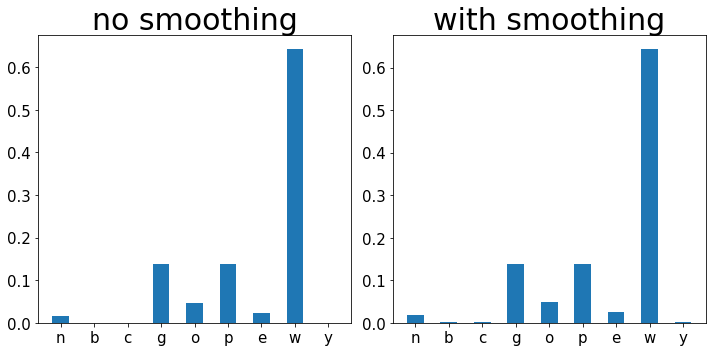

In [7]:
group = df_mush.groupby(0)
N_e = 0
for g in group:
    if(g[0] == 'e'):
        group = g[1].groupby(15)
        N_e = len(g[1])
        break
data = {}
for a in mush_atr[14]:
    data[a] = 0
for g in group:
    data[g[0]] = len(g[1]) / N_e
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.set_title('no smoothing',fontsize=30)
ax.bar(data.keys(),data.values(),width=0.5)
print("Probility of all possible features under edible without laplace smoothing:")
form = pd.DataFrame(data,index=['prob'])
display(form)
print()

data_lap = {}
for a in mush_atr[14]:
    data_lap[a] = 10 / (N_e+9)
for g in group:
    data_lap[g[0]] = (len(g[1])+10) / (N_e+9)
print("Probility of all possible features under edible with laplace smoothing:")
form = pd.DataFrame(data_lap,index=['prob'])
display(form)
print()
ax = fig.add_subplot(1,2,2)
ax.set_title('with smoothing',fontsize=30)
ax.bar(data_lap.keys(),data_lap.values(),width=0.5)
plt.tight_layout()
plt.show()
